In [1]:
% matplotlib inline

from __future__ import division
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, ccf
from statsmodels.tsa.tsatools import detrend
from scipy.spatial.distance import pdist, squareform
import scipy.signal as signal
import time as tm
import gsw as sw


from mpl_toolkits.basemap import Basemap, cm
from netCDF4 import Dataset

/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def checklon(data):
    cxx = (data['lon']).values # longitude

    # convert all longitude to longitude east
    cxx[cxx<0]= 360+cxx[cxx<0];
    data['lon_e'] = cxx
    cxbew = cxx
    cxbew[cxbew>180] = cxbew[cxbew>180]-360   
    data['lon'] = cxbew
    return data

def distance_sds(data):
    cruise = pd.unique(data['cruise'])
    distances = pd.DataFrame()    
    for c in cruise:
        temp = pd.DataFrame()
        temp = data.loc[(data['cruise']==c), ['cruise','file_time','lon','lat']]
        
        # calculate distance in km between points
        temp['dx'] = np.insert(sw.distance(temp['lon'].values, temp['lat'].values, 0),0,0)/1000
        temp['x'] = np.cumsum(temp['dx'])
        
        if c == cruise[0]:
            distances = distances.append(temp)
        else:
            distances = pd.concat([distances, temp], axis=0)
        del temp
    data = pd.merge(left = data, right = distances, how='left', left_on=['cruise','file_time','lat','lon'], right_on=['cruise','file_time','lat','lon'])
    #return distances

    return data 

def distance(data):
       
    # calculate distance in km between points
    data['dx'] = np.insert(sw.distance(data['lon'].values, data['lat'].values, 0),0,0)/1000
    data['x'] = np.cumsum(data['dx'])
    return data  

def interpdata(sds, prod, cruise, var):
    # we went to create a new dataframe which has the interpolated data for each track for all variables, 
    # and a position.
    tmp = sds.loc[(sds['cruise']==cruise)]
    intdata = pd.DataFrame()
    # set the interpolation distance 
    intdata['lon'] = tmp['lon']
    intdata['lat'] = tmp['lat']
    intdata['cruise'] = cruise
    intdata['x'] = tmp['x']
        
    for v in var:
        intdata[v] = np.interp(tmp['x'].values,prod['x'].values,prod[v].values)
          
    return intdata

def tracks(data):
    seg = []
    start = 0
    n = 1
    for i in range(len(data)):
        if ((data['dx'][i] > 20) | (data['dx'][i] < 0.01)):
            seg.append([data['cruise'][i], start, i-1, sum(data['dx'][start:i-1])])# - data['x'][start])])
                                                         
            n += 1
            start = i+1
    
    segments = pd.DataFrame(seg, columns = ['cruise', 'start', 'end', 'length']) 
    segments = segments.loc[(segments['length'] >= 200)]
    segments = segments.loc[(segments['end'] > 0)]
    segments['number'] = range(1, len(segments)+1)
    segments = segments.set_index(['number'])
    return segments

In [3]:
# import mega dataset
filePath = '/Users/sclayton/Google Drive/seaflow_data/abun_sds_opp.csv'
data = pd.read_csv(filePath, sep=',')

# only keep KM1304 data
data = data[(data['cruise']=='KiloMoana_1')]

filePath = r'/Users/sclayton/Google Drive/seaflow_data/sds_depth.csv'
depth = pd.read_csv(filePath)

filePath = r'/Users/sclayton/Google Drive/seaflow_data/sds_dist2coast.csv'
dcoast = pd.read_csv(filePath)

# add density 
data['density'] = sw.rho(data['salinity'].values,data['ocean_tmp'].values,0)
data = checklon(data)
               
# sort the dataframe so that it is in date/time order
data = pd.merge(data, depth, on=['cruise','file_time'], how='inner')
data = pd.merge(data, dcoast, on=['cruise','file_time'], how='inner')
data = data.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
data = data.reset_index(drop=True)

# now we have a dataframe with the total alongtrack distance for each cruise, 
# and the distance between points for each file.

clean = data[['cruise', 'file_time', 'lon', 'lon_e', 'lat', 'depth', 'dcoast', 'salinity', 'ocean_tmp', 'density', 'pico', 'synecho', 'picoeuk']]
clean['tot_chl'] = data['tot_chl']#/(data['file_duration']*data['opp.evt']*data['flow_rate'])
clean = clean.sort_values(by = ['cruise', 'file_time'],ascending=[1, 1])
clean = distance_sds(clean)


/Users/sclayton/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [4]:
# import O2/Ar data
filePath = r'/Users/sclayton/Google Drive/work/productivity_diversity/KM1314_O2Ar.csv'
prod = pd.read_csv(filePath)
prod['cruise'] = 'KiloMoana_1'
prod.rename(columns={'Lat': 'lat', 'Lon': 'lon'}, inplace=True)

# convert Timestamp to file_time

# interpolate the productivity data onto the seaflow track
prod = distance(prod)

var = ['Chl', 'TrueO2Ar', 'O2Arbiosat', 'Airseaflux']
intprod = interpdata(clean, prod, 'KiloMoana_1', var)

# check that interpolated data makes sense
print len(clean), len(intprod), np.max(intprod['x']), np.max(clean['x'])


11104 11104 6197.18845867 6197.18845867


In [5]:
# split the data into continuous segments at least 200 km long with no gaps bigger than 20 km.
segments = tracks(clean)

print segments.columns

Index([u'cruise', u'start', u'end', u'length'], dtype='object')


In [6]:
# get SST map for the period of the cruise, August 2013

# import SST data
sst_file = '/Users/sclayton/Google Drive/satellite_data/sst/SST_2013_08_mean.nc'
fh = Dataset(sst_file, mode='r')

# sst shape (1, 180, 360)
spacing = 0.5
lat = fh.variables['lat'][:]
lon = fh.variables['lon'][:]


ny = 180
nx = 360

sst = fh.variables['sst']

SST = (sst[:].reshape(ny, nx))
x,y = np.meshgrid(lon,lat)

fh.close()
del fh


/Users/sclayton/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


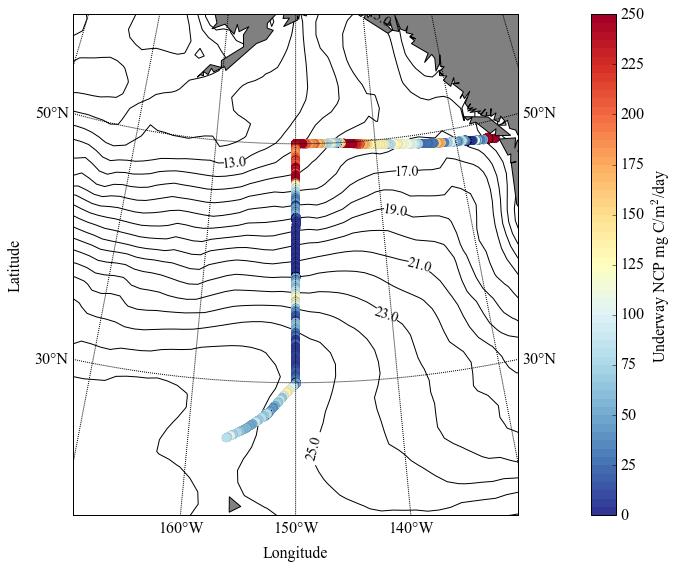

In [7]:
# plot up figure 1

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

fig1 = plt.figure(1, figsize=(13, 8), dpi = 600)
palette = plt.get_cmap('RdYlBu_r', 30)
m = Basemap(width=4000000,height=4500000,projection='lcc',
            resolution='c',lat_1=15.,lat_2=50,lat_0=40,lon_0=-150.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white')

palette = plt.get_cmap('RdYlBu_r', 60)
palette_g = plt.get_cmap('gray', 22)

plt.contourf(x, y, SST, cmap = palette, shading='flat')
m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1], fontsize=16)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1], fontsize=16)

xm, ym = m(x,y)
#m.plot(xm,ym,'.r')

levels= range(8,31,1)

#cax1 = m.contourf(xm, ym, SST, shading='flat', levels= range(8,31,1), cmap = palette_g)
cax1 = m.contour(xm, ym, SST, levels, shading='flat', colors='k', zorder = 1)

plt.clabel(cax1, levels[1::2],  # label every second level
           inline=1,
           fmt='%1.1f',
           fontsize=14, zorder = 2)


xx, yy = m(prod['lon'].values, prod['lat'].values)
cax2 = m.scatter(xx, yy, s=75, c=(prod['Airseaflux'].values*(12/1.4)), alpha=1,lw=0.01, vmin = 0, vmax = 250, cmap = palette)

plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xlabel('Longitude', fontsize = 16, labelpad = 30)
plt.ylabel('Latitude', fontsize = 16, labelpad = 50)

# cb1 = plt.colorbar(cax1, pad = 0.0)
# cb1.ax.tick_params(labelsize=16)
# cb1.set_label('Sea surface Temperature ($^o$C)', fontsize = 16)

cb2 = plt.colorbar(cax2, pad = 0.08)
cb2.ax.tick_params(labelsize=16)
cb2.set_label('Underway NCP mg C/m$^2$/day', fontsize = 16)

plt.show()

fig1.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/UnderwayNCP_SST.png', bbox_inches='tight', dpi=600)

In [8]:
# load chlorophyll data

chl_file = '/Users/sclayton/Google Drive/satellite_data/chlorophyll/August_2013.nc'
fh = Dataset(chl_file, mode='r')

# sst shape (1, 180, 360)
spacing = 0.5
latc = fh.variables['lat'][:]
lonc = fh.variables['lon'][:]


bad = -32767.0

ny = 2160
nx = 4320

chl = fh.variables['chlor_a']

CHL = (chl[:].reshape(ny, nx))
xc,yc = np.meshgrid(lonc,latc)

fh.close()
del fh


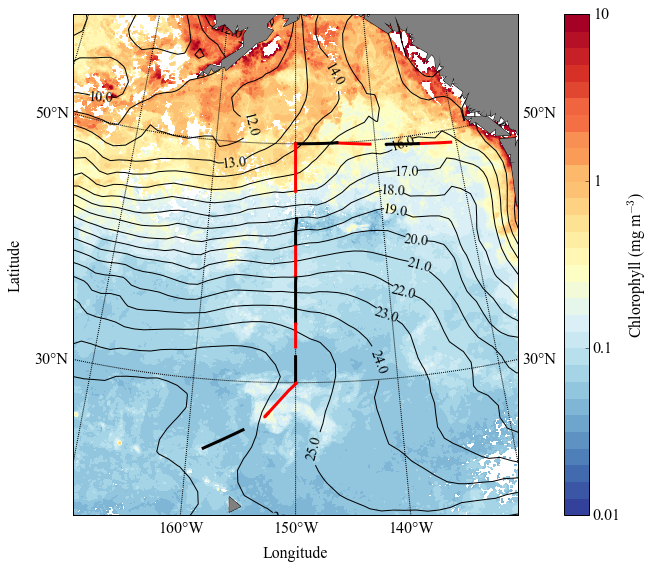

In [10]:
# make a similar figure with chlorophyll, SST contours and cruise track

# plot up figure 1, alternate version

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'font.family': 'serif'})
rcParams.update({'font.serif': 'Times New Roman'})

fig2 = plt.figure(1, figsize=(13, 8), dpi = 600)
palette = plt.get_cmap('RdYlBu_r', 30)
m = Basemap(width=4000000,height=4500000,projection='lcc',
            resolution='c',lat_1=15.,lat_2=50,lat_0=40,lon_0=-150.)
m.drawcoastlines()
m.drawmapboundary(fill_color='white')
m.fillcontinents(color='grey',lake_color='white', zorder = 4)

m.drawparallels(np.arange(10,90,20),labels=[1,1,0,1], fontsize=16)
m.drawmeridians(np.arange(-180,180,10),labels=[0,0,0,1], fontsize=16)

palette = plt.get_cmap('RdYlBu_r', 60)
palette_g = plt.get_cmap('gray', 22)

xm, ym = m(xc,yc)
cax1 = m.contourf(xm, ym, np.log10(CHL), shading='flat', levels = np.arange(-2, 1.1, 0.1), cmap = palette, zorder = 1)

# xm, ym = m(clean['lon'].values, clean['lat'].values)
# m.plot(xm,ym,'k', lw = 5)

col = ['r', 'k','r','k', 'r', 'k', 'r', 'k', 'r','k', 'r', 'k', 'r', 'k']

for i in range(1, len(segments)+1):
    a = segments['start'][i]
    b = segments['end'][i]
    
    xm, ym = m((data['lon'][a:b]).values,(data['lat'][a:b]).values)
    m.plot(xm,ym,color=col[i-1], lw=3)

xx, yy = m(x,y)
#m.plot(xm,ym,'.r')

levels= range(8,31,1)

cax2 = m.contour(xx, yy, SST, levels, shading='flat', colors='k', zorder = 2)

plt.clabel(cax2, levels[1::1],  # label every second level
           inline=1,
           fmt='%1.1f',
           fontsize=14, zorder = 3)


plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.xlabel('Longitude', fontsize = 16, labelpad = 30)
plt.ylabel('Latitude', fontsize = 16, labelpad = 50)

cb1 = plt.colorbar(cax1, ticks=[-2.0, -1, 0, 1], pad = 0.05)
cb1.ax.tick_params(labelsize=16)
cb1.ax.set_yticklabels(['0.01', '0.1', '1', '10'])
cb1.set_label('Chlorophyll (mg m$^{-3}$)', fontsize = 16)

plt.show()

fig2.savefig('/Users/sclayton/Documents/KM1304_lengthscales/figures/Chl_SST_tracks.png', bbox_inches='tight', dpi=600)

In [ ]:
# make plots of chlorophyll, NCP, T, S, phytoplankton groups, etc... along the track